In [1]:
import tensorflow as tf
import numpy as np

In [2]:
#model = tf.keras.models.load_model('../models/VGG16bn.h5', compile=False)
model = tf.keras.models.load_model('../models/Netslim/VGG16_NS20', compile=False)
model = model.layers[-1]

In [3]:
prune_model = model

In [9]:
netin = tf.keras.Input((224,224,3), dtype='uint8')
x = tf.cast(netin, 'float32')
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # !!!
#x = tf.nn.bias_add(x, [-123.68, -116.779, -103.939])
#x = tf.keras.applications.imagenet_utils.preprocess_input(x, mode='torch')
x = pruned_model(x)
model_lr = tf.keras.Model(inputs=netin, outputs=x)

In [10]:
model_lr.save('mobilenet_NS20')

In [4]:
prune_model.load_weights('mob_pre10nd.h5')

In [3]:
#model = model.layers[-1]
model.summary()

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 17)      476       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 224, 224, 17)      68        
_________________________________________________________________
block1_relu1 (Activation)    (None, 224, 224, 17)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 46)      7084      
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 224, 224, 46)      184       
_________________________________________________________________
block1_relu2 (Activation)    (None, 224, 224, 46)      0  

In [3]:
def bn_sparsity_train(layer):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        config = layer.get_config()
        config['gamma_regularizer'] = tf.keras.regularizers.l1(1e-3)
        newlayer = layer.__class__.from_config(config)
        return newlayer
        #return tfmot.sparsity.keras.prune_low_magnitude(newlayer)
    elif isinstance(layer, tf.keras.layers.Conv2D):
        newlayer = layer.__class__.from_config(layer.get_config())
        newlayer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)
        return newlayer
    return layer.__class__.from_config(layer.get_config())

In [32]:
del pruned_model, pruned_model2

In [4]:
prune_model = tf.keras.models.clone_model(model, clone_function=bn_sparsity_train)
for layer in prune_model.layers:
    if True:#isinstance(layer, tf.keras.layers.BatchNormalization):
        oldlayer = model.get_layer(layer.name)
        layer.set_weights(oldlayer.get_weights())

In [20]:
for l in prune_model.layers:
    if not isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False

In [17]:
count = 0
for l in model.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        count += len(l.gamma.numpy())
print(count)

26560


In [5]:
prune_model.layers[2].gamma_regularizer == None

False

In [4]:
import imagenet_full as imagenet
train_ds = imagenet.load_ds([224, 224])

In [5]:
train_ds = train_ds.map(lambda x,y: (tf.keras.applications.imagenet_utils.preprocess_input(x, mode='torch'),
                                     y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train_ds = train_ds.cache()
#train_ds = train_ds.shuffle(5000).repeat()

In [9]:
prune_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                    metrics=['accuracy'],
                    optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True))

In [10]:
b_sz = 64
ds = train_ds.batch(b_sz) #mob 5 a e-3, e-4 l1, e-4 l2
prune_model.fit(ds, epochs=5, initial_epoch=4, steps_per_epoch=50000//b_sz) #vgg 10 a e-5, e-3 l1
#out = prune_model.evaluate(ds, steps=50000//b_sz) res x a e-3, e-4 l1, e-4 l2

Epoch 5/5
3125/3125 [==============================] - 228s 73ms/step - loss: 27.0356 - accuracy: 0.9963


In [18]:
prune_model.fit(ds, epochs=10, initial_epoch=5, steps_per_epoch=50000//b_sz) 

Epoch 6/10
3125/3125 [==============================] - 177s 57ms/step - loss: 2.8067 - accuracy: 0.8801
Epoch 7/10
3125/3125 [==============================] - 178s 57ms/step - loss: 2.6948 - accuracy: 0.9092
Epoch 8/10
3125/3125 [==============================] - 179s 57ms/step - loss: 2.5885 - accuracy: 0.9394
Epoch 9/10
3125/3125 [==============================] - 179s 57ms/step - loss: 2.5170 - accuracy: 0.9570
Epoch 10/10
3125/3125 [==============================] - 179s 57ms/step - loss: 2.4628 - accuracy: 0.9694


In [11]:
ds = train_ds.batch(64)
prune_model.evaluate(ds, steps=50)

50/50 [==============================] - 6s 117ms/step - accuracy: 0.9887 - loss: 0.0627


[0.06266768276691437, 0.9887499809265137]

In [6]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [7]:
ds = train_ds.batch(32)
model.evaluate(ds, steps=50)

50/50 [==============================] - 3s 60ms/step - accuracy: 0.7219 - loss: 1.1082


[1.1082249879837036, 0.721875011920929]

In [14]:
prune_model.save('res_pre5x10.h5')

In [26]:
prune_model.save('vgg_sparse_train15.h5')

In [10]:
prune_model.load_weights('vgg_sparse_train.h5')

In [2]:
class ChannelSelectWrapper(tf.keras.layers.Layer):
    def __init__(self, layer, indices, channels_last=True, **kwargs):
        super(ChannelSelectWrapper, self).__init__(**kwargs)
        self.layer = layer
        self.indices = indices
        self.channels_last = channels_last

    def call(self, inputs):
        ax = -1 if self.channels_last else 1
        return self.layer(tf.gather(inputs, self.indices, axis=ax))
    
    def get_config(self):
        config = super(ChannelSelectWrapper, self).get_config()
        config.update({'layer':self.layer, 'indices':self.indices, 'channels_last': self.channels_last})
        return config

In [3]:
import numpy as np
# identificar el cutoff
# identificar canales a podar
# identificar capa conv de entrada
# eliminar canales de esa capa
# identificar capas que tienen como entrada la capa bn (despues de relu)
# eliminar canales de ahi
# extra pasos para residuales
# quizas es mas facil hacer red nueva y traspasar pesos de la antigua

def prune_clone(layer, to_prune):
    config = layer.get_config() 
    try:
        if layer.input.name in to_prune and 'use_bias' in config:
            config['use_bias'] = to_prune[layer.input.name] # True
        if layer.output.name in to_prune and 'filters' in config:
            config['filters'] = to_prune[layer.output.name] # unprunned channels
    except AttributeError:
        pass
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        config['gamma_regularizer'] = None
    newlayer = layer.__class__.from_config(config)
    if layer.name in to_prune: # unprunned indices
        return ChannelSelectWrapper(newlayer, to_prune[layer.name], name=config['name']+'_W') 
    return newlayer

In [4]:

def apply_pruning(model, fraction): # fraction es la fraccion de canales eliminados
    assert fraction < 1, 'fraction must be <1'
    bn_channels = []
    bn_idx = []
    num_channels = 0
    # recoger todos los gammas
    for i in range(len(model.layers)):
        layer = model.layers[i]
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            weights = layer.gamma.numpy()
            num_channels += weights.size
            bn_channels.append(weights)
            bn_idx.append(i)
    gammas = np.empty(num_channels)
    idx = 0
    for l in bn_channels:
        length = l.size
        gammas[idx:idx+length] = l
        idx += length
    gammas.sort()
    cutoff = gammas[int(round(fraction * num_channels))] # se determina el cutoff
    prune_ref = dict()
    in_connect = dict() # dict que dice a que capa (bn) va x tensor, parte al reves
    out_connect = dict() # dict de sets con capas a la salida de x tensor
    unprunnable = set()
    for i in range(len(model.layers)): # determinar canales que deben podarse
        if i in bn_idx: # si es capa batchnorm
            bn_layer =  model.layers[i]
            bn_gammas = bn_layer.gamma.numpy()
            not_pruning = np.sum(bn_gammas > cutoff)
            if bn_gammas.size > not_pruning: # si hay canales podados
                prune_ref[bn_layer.input.name] = not_pruning # nº de canales que debe tener conv anterior
                in_connect[bn_layer.input.name] = bn_layer.name # para determinar la conv que va conectada
                out_connect[bn_layer.output.name] = set() # aqui iran las capas conectadas al out
                
    changed = True # propagar busqueda de foreprune
    while changed: # no se consideran capas reusadas (?)
        changed = False
        for l in model.layers:
            if isinstance(l.input, list): # si es add u otro
                for i in l.input:
                    if i.name in out_connect: # si bn conectada a la entrada
                        out_connect[i.name].add(l) 
                        unprunnable.add(i.name) # no podar, falta buscar capa conectada a tensor
            elif l.input.name in out_connect: # si esta a la salida de una bn
                out_connect[l.input.name].add(l)
                channel_passthru = type(l) in (tf.keras.layers.Activation, tf.keras.layers.ReLU,
                                               tf.keras.layers.MaxPool2D, tf.keras.layers.ZeroPadding2D, 
                                               tf.keras.layers.Dropout)# tf.keras.layers.DepthwiseConv2D)
                if channel_passthru and l.output.name not in out_connect:
                    out_connect[l.output.name] = set() # propagar
                    changed = True
                if type(l) in (tf.keras.layers.DepthwiseConv2D, 
                               tf.keras.layers.GlobalAveragePooling2D,
                               tf.keras.layers.Flatten):
                    unprunnable.add(l.input.name + 'HARD') # no podar si va a DW (?) o global/flatten (hard)
                elif isinstance(l, tf.keras.layers.Conv2D):
                    prune_ref[l.input.name] = True 
                                
    changed = True
    while changed: # propagar busqueda de backprune
        changed = False
        for l in model.layers: # TODO: considerar mas tipos de capa vvv ?
            if l.output.name in in_connect: 
                if type(l) in (tf.keras.layers.Add,):
                    unprunnable.add(in_connect[l.output.name]) # si bn tiene add en entrada, no podar
                    prune_ref.pop(l.output.name, None) # las add no se pueden tocar
                    continue
                elif isinstance(l, tf.keras.layers.DepthwiseConv2D) and l.output.name in prune_ref:
                    prune_ref[l.output.name] = l.name # se deja anotado su nombre para despues
                    unprunnable.add(in_connect[l.output.name] + 'DW')
                elif not isinstance(l, tf.keras.layers.Conv2D):
                    prune_ref[l.input.name] = prune_ref.pop(l.output.name) # propagar busqueda
                    in_connect[l.input.name] = in_connect.pop(l.output.name)
                    changed = True
            chk_unprunnable = l.output.name in unprunnable or l.output.name+'HARD' in unprunnable
            if chk_unprunnable: # significa que su salida va a un add (o DW)
                hardness = '' if l.output.name in unprunnable else 'HARD'
                if isinstance(l, tf.keras.layers.BatchNormalization):
                    unprunnable.add(l.name + hardness)
                elif not isinstance(l, tf.keras.layers.Add): # u otras que tomen varios in
                    unprunnable.add(l.input.name + hardness)
                    changed = True
                unprunnable.remove(l.output.name + hardness)

    for i in list(in_connect.keys()):
        in_connect[in_connect.pop(i)] = i   
                
    for l in list(unprunnable): # son puros nombres de bn
        actually_dw = False
        if l[-4:] == 'HARD': # las hard unprunnable no se tocan en absoluto    
            l_name = l[:-4]
            hardness = True
            unprunnable.add(l_name)
            unprunnable.remove(l)
        else:
            l_name = l
            if l[-2:] == 'DW':
                l_name = l[:-2]
                unprunnable.remove(l)
                actually_dw = True # no es impodable, pero este codigo me sirve para tratar las dw tbm
            hardness = False
        bn_layer = model.get_layer(l_name)
        bn_gammas = bn_layer.gamma.numpy()
        indices = bn_gammas > cutoff 
        if actually_dw: # se asume que la dw esta justo antes a la bn
            prune_ref[prune_ref.pop(bn_layer.input.name)] = np.flatnonzero(indices)
            continue
        if not hardness:
            out_name = bn_layer.output.name
            for out in out_connect[out_name]: # wrapear todas las capas a la salida que no sean add
                if not isinstance(out, tf.keras.layers.Add) and indices.size > indices.sum():
                    prune_ref[out.name] = np.flatnonzero(indices)
        prune_ref.pop(in_connect[l_name], None) # la conv conectada antes del bn no se puede prunear
            

    #determinar capas wrapeables x?
    #buscar capas wrapeables x
    #determinar indices x
    #proceder con procesamiento habitual para capa wrapeada x
    #tratar capas depthwise /, impodables (global x, flatten), wrap x
    
    new_model = tf.keras.models.clone_model(model, clone_function=lambda l: prune_clone(l, prune_ref))
                 
    forward_prune = dict()
    backward_prune = dict()
    for i in range(len(new_model.layers)):
        oldlayer = model.layers[i] 
        newlayer = new_model.layers[i]
        if isinstance(newlayer, ChannelSelectWrapper): 
            newlayer = newlayer.layer # se ajusta la referencia para modificar la capa wrapeada (no el wrap)
        
        if isinstance(oldlayer, tf.keras.layers.BatchNormalization):
            weights = oldlayer.get_weights()
            unprunned = weights[0] > cutoff
            if oldlayer.name in unprunnable: # si es impodable no se hace nada
                newlayer.set_weights(weights)
            else: # si no, se copian params de canales no podados
                newlayer.set_weights([weights[n][unprunned] for n in range(4)])
            if unprunned.size == unprunned.sum(): # se ve si hubo podas o no, depende de magnitudes de gamma
                continue
            elif oldlayer.name not in unprunnable: # con esto despues se ve qué pesos copiar en la
                backward_prune[in_connect[oldlayer.name]] = unprunned # conv que va antes de esta bn
            outref = oldlayer.output.name
            activ = 'linear'
            changed = True
            while changed: # como hay poda se busca capas conectadas a la salida para ajustar sus params
                changed = False # la busqueda se propaga por la red para encontrar todas las conv conectadas 
                for outlayer in out_connect[outref]: # TODO agregar mas capas de activacion
                    if isinstance(outlayer, tf.keras.layers.ReLU):
                        activ = 'relu' + str(outlayer.get_config()['max_value'])
                        outref = outlayer.output.name
                        changed = True
                        break
                    elif isinstance(outlayer, tf.keras.layers.Activation):
                        activ = outlayer.get_config()['activation']
                        outref = outlayer.output.name
                        changed = True
                        break
                    elif type(outlayer) in (tf.keras.layers.ZeroPadding2D, 
                                            tf.keras.layers.MaxPooling2D): # quiza algun dia agregar dropout
                        outref = outlayer.output.name
                        changed = True
                        break
            betas = weights[1]
            if 'relu' in activ: # hay que rescatar y propagar los betas de los canales podados
                saturate = None if activ=='relu' else float(activ[4:])
                betas = np.clip(betas, 0, saturate)
            elif activ == 'sigmoid':
                betas = 1 / (1 + np.exp(-betas))
            elif activ == 'softmax':
                betas = np.exp(betas) / np.sum(np.exp(betas))
            forward_prune[outref] = (unprunned, betas) # se guarda aca para ajustar los pesos de entrada 
                                     # de capas superiores a la salida de esta
        elif not isinstance(oldlayer, tf.keras.layers.Conv2D):
            newlayer.set_weights(oldlayer.get_weights())
            
    for i in range(len(new_model.layers)): # 2da pasada para cubrir las conv
        oldlayer = model.layers[i] 
        newlayer = new_model.layers[i]
        if isinstance(newlayer, ChannelSelectWrapper):
            newlayer = newlayer.layer # idem arriba
            
        if isinstance(oldlayer, tf.keras.layers.Conv2D):
            weights = oldlayer.get_weights()
            #if isinstance(oldlayer, tf.keras.layers.DepthwiseConv2D): #TODO: adaptar prune a dw
                #newlayer.set_weights(weights) # por ahora no se tocan las depthwise
                #continue
            is_dw = isinstance(oldlayer, tf.keras.layers.DepthwiseConv2D)
            if oldlayer.output.name in backward_prune: # ojo: se asume que la bn va justo despues de la conv
                backprune = backward_prune[oldlayer.output.name] # vector de bools, viene desde adelante
                if is_dw:
                    weights = [weights[n][:,:,backprune,:] for n in range(len(weights))]
                else:
                    weights = [weights[n][...,backprune] for n in range(len(weights))]
            else:
                backprune = np.full(weights[0].shape[-1], True) 
            if oldlayer.input.name in forward_prune and not is_dw: # para DW nunca deberia cumplirse <<<?
                if not oldlayer.use_bias and newlayer.use_bias:
                    weights.append(np.zeros(backprune.sum()))
                foreprune, betas = forward_prune[oldlayer.input.name] # el foreprune viene desde atras
                ker_sums = weights[0].sum(axis=(0,1)) # se rescatan kernels que van a canales podados
                rescued_betas = (betas * ~foreprune).reshape((len(betas),1)) # para combinarlos con los betas
                weights[1] += (rescued_betas * ker_sums).sum(axis=0)
                weights[0] = weights[0][:,:,foreprune,:]
            newlayer.set_weights(weights)
            
    return new_model
        

- programar capa add con rellenos 2
- programar busqueda de capas conectadas al out 2
- clonar pesos filtrando prunes 1  
- agregar sum kernel*a(beta) a los bias (y bordes?) 1
- configurar adds modificados (ident con filas relleno?) 1

In [51]:
model.layers[5].get_weights()[0].shape

(3, 3, 32, 1)

In [16]:
import pdb # las conv compartidas entre bns arruinan el esquema de nombres 
#pdb.set_trace()
pruned_model = apply_pruning(prune_model, 0.2)

In [17]:
pruned_model.save('vgg16_pruned20')

W0328 17:23:56.301108 140559225677568 deprecation.py:506] From /home/alexis/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
prune_model = tf.keras.models.load_model('vgg16_pruned20', compile=False)

In [3]:
pruned_model.load_weights('mobnet_20prun10.h5')

In [6]:
prune_model.summary()

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 17)      476       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 224, 224, 17)      68        
_________________________________________________________________
block1_relu1 (Activation)    (None, 224, 224, 17)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 46)      7084      
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 224, 224, 46)      184       
_________________________________________________________________
block1_relu2 (Activation)    (None, 224, 224, 46)      0  

In [19]:
pruned_model.summary()

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 17)      476       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 224, 224, 17)      68        
_________________________________________________________________
block1_relu1 (Activation)    (None, 224, 224, 17)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 46)      7084      
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 224, 224, 46)      184       
_________________________________________________________________
block1_relu2 (Activation)    (None, 224, 224, 46)      0  

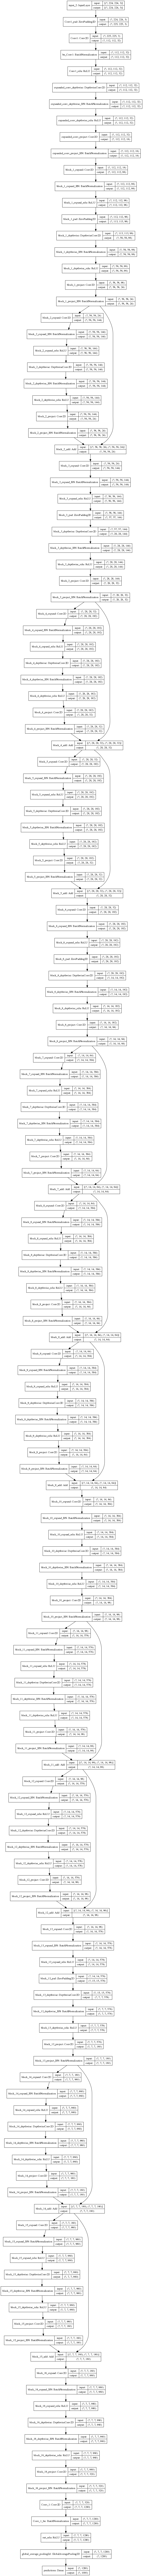

In [68]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=72)

In [20]:
import matplotlib.pyplot as plt
num_channels = 0
bn_channels = []
wat = []
for i in range(len(prune_model.layers)):
    layer = pruned_model.layers[i]
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        weights = layer.gamma.numpy()
        num_channels += weights.size
        bn_channels.append(weights)
        if min(weights) < 0:
            wat.append(layer.name)
gammas = np.empty(num_channels)
idx = 0
for l in bn_channels:
    length = l.size
    gammas[idx:idx+length] = l
    idx += length

In [15]:
len(gammas)

24872

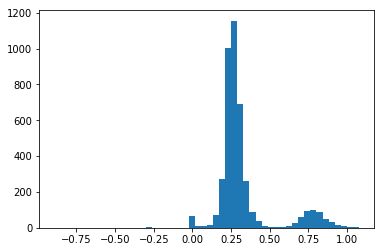

In [7]:
plt.hist(gammas, 50) # orig
plt.show()

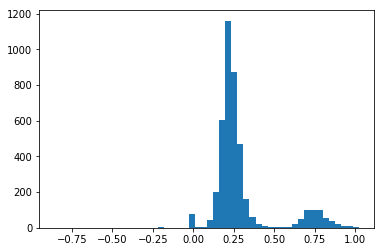

In [13]:
plt.hist(gammas, 50) # pre-prune
plt.show()

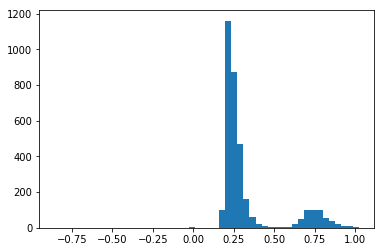

In [21]:
plt.hist(gammas, 50) # post-prune
plt.show()

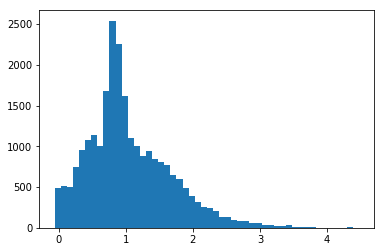

In [16]:
plt.hist(gammas, 50) # post-train
plt.show()

In [12]:
pruned_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                    metrics=['accuracy'],
                    optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True))

In [8]:
import imagenet_full as imagenet

train_ds = imagenet.load_ds((224,224), mode='val', data_path='../ILSVRC/')

In [6]:
box = (224,224)
train_path = '../ILSVRC/Data/CLS-LOC/train/'
ds = train_ds.shuffle(1280000).repeat()
ds = ds.map(lambda x, y: (imagenet.load_image(x, box, train_path), y), 
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(32)
ds = ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x),
                          y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
pruned_model.layers[0].get_config()

{'batch_input_shape': (None, 224, 224, 3),
 'dtype': 'float32',
 'name': 'input_1',
 'ragged': False,
 'sparse': False}

In [13]:
prune_model.evaluate(train_ds.batch(64), steps=50) #vgg

50/50 [==============================] - 6s 121ms/step - accuracy: 0.0012 - loss: 18.8845


[18.884517669677734, 0.0012499999720603228]

In [18]:
b_sz = 32
#ds = train_ds.batch(b_sz)
pruned_model.fit(ds, epochs=10, initial_epoch=5, steps_per_epoch=1281167//b_sz) #1
#out = prune_model.evaluate(ds, steps=50000//b_sz)

Epoch 6/10
40036/40036 [==============================] - 7689s 192ms/step - accuracy: 0.4094 - loss: 1.8357
Epoch 7/10
40036/40036 [==============================] - 7719s 193ms/step - accuracy: 0.4301 - loss: 1.7564
Epoch 8/10
40036/40036 [==============================] - 7422s 185ms/step - accuracy: 0.4508 - loss: 1.6811
Epoch 9/10
40036/40036 [==============================] - 7042s 176ms/step - accuracy: 0.4755 - loss: 1.6007
Epoch 10/10
40036/40036 [==============================] - 7212s 180ms/step - accuracy: 0.4931 - loss: 1.5444


In [19]:
pruned_model.save_weights('mobnet_20prun10.h5') #10%-72, 20%-36

In [8]:
b_sz = 64
pruned_model.fit(ds, epochs=10, initial_epoch=5, steps_per_epoch=1281167//b_sz)

Epoch 6/10
20018/20018 [==============================] - 7030s 351ms/step - loss: 1.3657 - accuracy: 0.5015
Epoch 7/10
20018/20018 [==============================] - 5611s 280ms/step - loss: 1.2136 - accuracy: 0.5531
Epoch 8/10
20018/20018 [==============================] - 6060s 303ms/step - loss: 1.0638 - accuracy: 0.6095
Epoch 9/10
20018/20018 [==============================] - 5662s 283ms/step - loss: 0.9039 - accuracy: 0.6699
Epoch 10/10
20018/20018 [==============================] - 5858s 293ms/step - loss: 0.7795 - accuracy: 0.7185


In [9]:
pruned_model.save('vgg16_30prun10.h5')

In [4]:
pruned_model = tf.keras.models.load_model('mobnet_pruned30', compile=False)

In [7]:
inp = tf.keras.Input((224,224,3))
x = tf.cast(inp, 'float32')
#x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = tf.keras.applications.imagenet_utils.preprocess_input(x, mode='torch')
x = prune_model(x)
prune_model = tf.keras.Model(inputs=inp, outputs=x)

In [11]:
pruned_model = prune_model

In [7]:
pruned_model.save('VGG16bn_ns30')

W0319 19:00:34.267042 140291355711232 deprecation.py:506] From /home/alexis/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
pruned_model.layers[0]

AttributeError: 'InputLayer' object has no attribute 'get_confiig'

In [208]:
res = tf.keras.applications.ResNet50V2()


In [ ]:
res.layers[10].get_config()

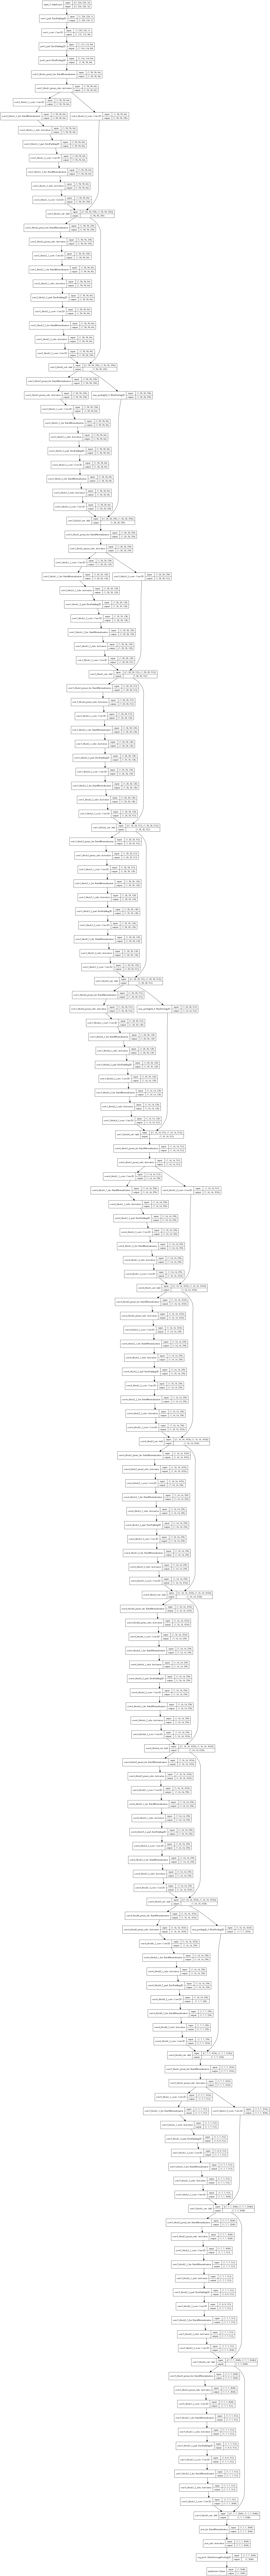

In [210]:
tf.keras.utils.plot_model(res, show_shapes=True, dpi=72)

In [15]:
mymodel = tf.keras.applications.VGG16()

In [6]:
mymodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
mymodelbn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 224, 224, 64)      256       
_________________________________________________________________
block1_relu1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 224, 224, 64)      256       
_________________________________________________________________
block1_relu2 (Activation)    (None, 224, 224, 64)      0     

In [29]:
netin = tf.keras.Input((224,224,3))
net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', name='block1_conv1')(netin)
net = tf.keras.layers.BatchNormalization(name='block1_bn1')(net)
net = tf.keras.layers.Activation('relu', name='block1_relu1')(net)
net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', name='block1_conv2')(net)
net = tf.keras.layers.BatchNormalization(name='block1_bn2')(net)
net = tf.keras.layers.Activation('relu', name='block1_relu2')(net)
net = tf.keras.layers.MaxPool2D(pool_size=2, name='block1_pool')(net)
net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', name='block2_conv1')(net)
net = tf.keras.layers.BatchNormalization(name='block2_bn1')(net)
net = tf.keras.layers.Activation('relu', name='block2_relu1')(net)
net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', name='block2_conv2')(net)
net = tf.keras.layers.BatchNormalization(name='block2_bn2')(net)
net = tf.keras.layers.Activation('relu', name='block2_relu2')(net)
net = tf.keras.layers.MaxPool2D(pool_size=2, name='block2_pool')(net)
net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', name='block3_conv1')(net)
net = tf.keras.layers.BatchNormalization(name='block3_bn1')(net)
net = tf.keras.layers.Activation('relu', name='block3_relu1')(net)
net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', name='block3_conv2')(net)
net = tf.keras.layers.BatchNormalization(name='block3_bn2')(net)
net = tf.keras.layers.Activation('relu', name='block3_relu2')(net)
net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', name='block3_conv3')(net)
net = tf.keras.layers.BatchNormalization(name='block3_bn3')(net)
net = tf.keras.layers.Activation('relu', name='block3_relu3')(net)
net = tf.keras.layers.MaxPool2D(pool_size=2, name='block3_pool')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block4_conv1')(net)
net = tf.keras.layers.BatchNormalization(name='block4_bn1')(net)
net = tf.keras.layers.Activation('relu', name='block4_relu1')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block4_conv2')(net)
net = tf.keras.layers.BatchNormalization(name='block4_bn2')(net)
net = tf.keras.layers.Activation('relu', name='block4_relu2')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block4_conv3')(net)
net = tf.keras.layers.BatchNormalization(name='block4_bn3')(net)
net = tf.keras.layers.Activation('relu', name='block4_relu3')(net)
net = tf.keras.layers.MaxPool2D(pool_size=2, name='block4_pool')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block5_conv1')(net)
net = tf.keras.layers.BatchNormalization(name='block5_bn1')(net)
net = tf.keras.layers.Activation('relu', name='block5_relu1')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block5_conv2')(net)
net = tf.keras.layers.BatchNormalization(name='block5_bn2')(net)
net = tf.keras.layers.Activation('relu', name='block5_relu2')(net)
net = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', name='block5_conv3')(net)
net = tf.keras.layers.BatchNormalization(name='block5_bn3')(net)
net = tf.keras.layers.Activation('relu', name='block5_relu3')(net)
net = tf.keras.layers.MaxPool2D(pool_size=2, name='block5_pool')(net)
net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(net)
net = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(net)
net = tf.keras.layers.Dense(1000, activation='softmax', name='predictions')(net)

mymodelbn = tf.keras.Model(inputs=netin, outputs=net)

In [2]:
mymodelbn = tf.keras.models.load_model('vgg16bn.h5')

In [19]:
for lay in mymodel.layers:
    if isinstance(lay, tf.keras.layers.InputLayer):
        continue
    newlay = mymodelbn.get_layer(lay.name)
    newlay.set_weights(lay.get_weights())
    newlay.trainable = False

In [3]:
for lay in mymodelbn.layers:
    lay.trainable = True
    if isinstance(lay, tf.keras.layers.Conv2D):
        lay.kernel_regularizer = tf.keras.regularizers.l2(5e-4)

In [23]:
for lay in mymodelbn.layers:
    if isinstance(lay, tf.keras.layers.BatchNormalization):
        lay.trainable = True
        weights = lay.get_weights()
        weights[0] = (weights[3]+1e-3)**0.5
        weights[1] = weights[2]
        lay.set_weights(weights)
    else:
        lay.trainable = False

In [7]:
mymodelbn.layers[5].weights

[<tf.Variable 'block1_bn2/gamma:0' shape=(64,) dtype=float32, numpy=
 array([3.3248482, 2.2207172, 2.9399395, 2.9604077, 3.1361465, 4.059933 ,
        3.5524879, 2.3091109, 2.4650803, 1.9580767, 3.471631 , 1.7880869,
        3.9471078, 4.8166203, 1.3849562, 2.9671235, 2.3751824, 4.8609695,
        4.376847 , 2.6468651, 4.310216 , 2.7563753, 1.4293884, 1.7349968,
        3.6422622, 2.19007  , 5.0107946, 4.956781 , 4.446767 , 4.19366  ,
        3.0387273, 2.8267446, 4.046962 , 4.500625 , 3.9903471, 2.730892 ,
        1.5917772, 4.9002833, 2.08115  , 1.5666115, 3.930229 , 3.6417775,
        2.317184 , 2.9226334, 3.1916997, 4.919594 , 3.0486028, 3.1823936,
        1.4277424, 3.3329816, 4.141326 , 2.0461824, 4.093373 , 4.552799 ,
        1.8591866, 3.3956785, 3.8651805, 2.5816615, 3.60299  , 2.7294781,
        3.8515265, 2.4602973, 3.2600932, 1.8438419], dtype=float32)>,
 <tf.Variable 'block1_bn2/beta:0' shape=(64,) dtype=float32, numpy=
 array([ 0.6154098 ,  0.6942873 ,  1.6703159 ,  3.315

In [9]:
(4.93+1e-3)**0.5

2.2205855083738615

In [5]:
train_ds = train_ds.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(x),y),
                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(5000).repeat()

In [ ]:
mymodelbn.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(1e-3))

In [16]:
mymodel.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(1e-4))

In [17]:
mymodel.evaluate(ds, steps=20)

20/20 [==============================] - 6s 309ms/step - loss: 1.1943 - accuracy: 0.7148


[1.1942791938781738, 0.71484375]

In [24]:
mymodelbn.evaluate(ds, steps=20)

20/20 [==============================] - 6s 311ms/step - loss: 1.2569 - accuracy: 0.7063


[1.256935715675354, 0.706250011920929]

In [28]:
# cargar dataset
b_sz = 64
#ds = train_ds.batch(b_sz)
mymodelbn.fit(ds, epochs=4, steps_per_epoch=50000//b_sz)

Epoch 1/4
781/781 [==============================] - 372s 476ms/step - loss: 6.1448 - accuracy: 0.0111
Epoch 2/4
781/781 [==============================] - 226s 290ms/step - loss: 6.0611 - accuracy: 0.0139
Epoch 3/4
781/781 [==============================] - 227s 290ms/step - loss: 5.9809 - accuracy: 0.0181
Epoch 4/4
781/781 [==============================] - 227s 291ms/step - loss: 5.9051 - accuracy: 0.0219


In [16]:
mymodelbn = tf.keras.models.load_model('vgg16bn.h5')

In [15]:
del mymodelbn

In [ ]:
tf.me

In [12]:
mymodelbn.layers[5].weights

[<tf.Variable 'block1_bn2/gamma:0' shape=(64,) dtype=float32, numpy=
 array([1.0763072 , 0.64490336, 0.686257  , 0.45966756, 0.8841639 ,
        1.1912894 , 0.88227373, 0.7818808 , 1.4595435 , 0.69261736,
        0.9673616 , 0.45006895, 1.0838416 , 1.037093  , 1.0535727 ,
        0.7376242 , 1.3289734 , 0.7799503 , 1.0698271 , 0.87708455,
        1.0335851 , 0.8877937 , 1.0858272 , 0.55155903, 0.8546405 ,
        0.96532977, 0.8283065 , 1.2024633 , 1.1370716 , 1.3186259 ,
        0.95542556, 0.68307817, 0.7457384 , 0.95727813, 1.2307334 ,
        0.872377  , 0.26041302, 1.1646315 , 0.86488014, 0.66354567,
        0.867676  , 0.67565995, 0.9647642 , 1.002698  , 0.5640234 ,
        1.1411139 , 0.9770097 , 1.0066544 , 0.2972689 , 1.1641455 ,
        1.1554756 , 0.76719517, 0.94622093, 0.8940387 , 0.69358087,
        1.0296401 , 1.0486504 , 1.0969362 , 0.9543382 , 0.9511612 ,
        0.672971  , 0.75655144, 0.86180294, 0.46273762], dtype=float32)>,
 <tf.Variable 'block1_bn2/beta:0' shape=(